<a href="https://colab.research.google.com/github/hoangdungnguyen/PL_deeplearning/blob/master/NNdropout_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install MulticoreTSNE
%matplotlib inline
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time

torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm_notebook


mnist = input_data.read_data_sets("", one_hot=True)

  Created wheel for MulticoreTSNE: filename=MulticoreTSNE-0.1-cp36-cp36m-linux_x86_64.whl size=68507 sha256=c221af5d051fdee97567dc073c6b544fef11ca60cb56bdd11881611253abe62b
  Stored in directory: /root/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
##### Define hyper-parameters #####

# Dropout parameters
dropoutRate_0 = 0.
dropoutRate_1 = 0.5 #ref

# NN parameters
inputN = 784
hiddenN = 392
hiddenN2 = 256
hiddenN3 = 128
outputN = 10


# iteraction parameters
num_labelled = 100
trainingEpochs = 200
PLtrainingEpochs = 500
train_BS = 32 # ref
unlabel_BS = 256 #ref 59900// (num_labelled)

# balancing coefficient
T1 = 100 #ref
T2 = 600 #ref
a = 0. #ref
af = 3. #ref

# SGD with dynamic momentum
learningRate = 1.5 # ref
T = 500 #ref
k = 0.998 #ref
pi = 0.5 #ref
pf = 0.99 #ref

# loading test
x_test = mnist.test.images
y_test = mnist.test.labels
test_BS = len(x_test)// (num_labelled//train_BS)

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test.argmax(1)).type(torch.LongTensor) 
test = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_BS, shuffle = True, num_workers = 8)

Labeled data size : (100, 784)
Unlabeled data size : (54900, 784)
Proportion of class label in train data: 
    0   1   2   3   4  5   6   7   8   9
0   0   1   2   3   4  5   6   7   8   9
1  10  11  10  10  10  9  10  10  10  10


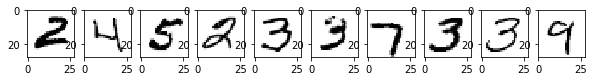

[2 4 5 2 3 3 7 3 3 9]


In [3]:
def random_data_generator(nb_PLdata = False):
  stratSplit = StratifiedShuffleSplit(test_size=100, n_splits=1)
  stratSplit.get_n_splits(mnist.train.images, np.argmax(mnist.train.labels, axis = 1))
  for train_index, test_index in stratSplit.split(X = mnist.train.images,y = mnist.train.labels):
    x_train = mnist.train.images[test_index]
    y_train = mnist.train.labels[test_index]
    if nb_PLdata == False :
      x_PL = mnist.train.images[train_index]
    else:
      x_PL = mnist.train.images[train_index][0:nb_PLdata]
  return x_train, y_train, x_PL

x_train_viewtest, y_train_viewtest, x_PL_viewtest = random_data_generator()
print('Labeled data size :', x_train_viewtest.shape)
print('Unlabeled data size :', x_PL_viewtest.shape)
print('Proportion of class label in train data: ')

print(pd.DataFrame(np.unique(np.argmax(y_train_viewtest,1), return_counts = True)).to_string())

f, a = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    a[i].imshow(np.reshape(x_train_viewtest[i], (28, 28)), cmap='Greys',  interpolation='nearest')
plt.show()

print(y_train_viewtest[0:10].argmax(1))

In [0]:
def data_build(nb_PLdata = False):
  x_train, y_train, x_PL = random_data_generator(nb_PLdata)
  x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
  y_train = torch.from_numpy(y_train.argmax(1)).type(torch.LongTensor) 

  x_PL = torch.from_numpy(x_PL).type(torch.FloatTensor)

  train = torch.utils.data.TensorDataset(x_train, y_train)
  train_loader = torch.utils.data.DataLoader(train, batch_size = train_BS, shuffle = True, num_workers = 8)

  unlabeled = torch.utils.data.TensorDataset(x_PL)
  unlabeled_loader = torch.utils.data.DataLoader(unlabeled, batch_size = unlabel_BS, shuffle = True, num_workers = 8)

  return train_loader, unlabeled_loader

In [0]:

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
    
            self.fc1 = nn.Linear(inputN, hiddenN)
            self.fc2 = nn.Linear(hiddenN, hiddenN2)
            self.fc3 = nn.Linear(hiddenN2, outputN)
            self.log_softmax = nn.LogSoftmax(dim = 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc2(x))
            x = F.dropout(x, training=self.training)
            x = F.relu(self.fc3(x))
            x = self.log_softmax(x)
            return x

Now let's define a function to evaluate the network and get loss and accuracy values. 

In [0]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.cuda()
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels.cuda()).sum()
            loss += F.nll_loss(output, labels.cuda()).item()

    return (float(correct)/len(test)) *100, (loss/len(test_loader))

First, let's train the model on the labeled set for 300 epochs

In [0]:
def train_supervised(model, train_loader, test_loader, verbose_step = 10):
    test_acc_list = []
    test_loss_list = []
    optimizer = torch.optim.SGD( model.parameters(), lr = 0.1)
    model.train()
    for epoch in tqdm_notebook(range(trainingEpochs)):
        correct = 0
        running_loss = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            
            output = model(X_batch)
            labeled_loss = F.cross_entropy(output, y_batch)
                       
            optimizer.zero_grad()
            labeled_loss.backward()
            optimizer.step()
            running_loss += labeled_loss.item()
        
        if (epoch+1) %verbose_step == 0 or epoch ==0:
            test_acc, test_loss = evaluate(model, test_loader)
            test_acc_list.append(test_acc)
            test_loss_list.append(test_loss)
            print('Epoch: {} : Train Loss = {:.5f} | Test Acc = {:.5f} | Test Loss= {:.3f} '.format(epoch+1, running_loss/(10 * num_labelled), test_acc, test_loss))
            model.train()
    return test_acc_list, test_loss_list    

In [0]:
def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [0]:
def semisup_train(model, train_loader, unlabeled_loader, test_loader, verbose_step = 10):
    alpha_list = []
    test_acc_list = []
    test_loss_list = []
    begin = time.time()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1,)
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 0 

    model.train()
    for epoch in tqdm_notebook(range(PLtrainingEpochs)):
        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].cuda()
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * F.cross_entropy(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()

            # For every 50 unlabeled batches train one epoch on labeled data 
            if batch_idx % 50 == 0:
              for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                  X_batch = X_batch.cuda()
                  y_batch = y_batch.cuda()
                  output = model(X_batch)
                  labeled_loss = F.cross_entropy(output, y_batch)

                  optimizer.zero_grad()
                  labeled_loss.backward()
                  optimizer.step()
                
              # Now we increment step by 1
              step += 1
                
        if (epoch+1) %verbose_step == 0 or epoch ==0:  
            test_acc, test_loss =evaluate(model, test_loader)
            print('Epoch: {} : Time = {:.2f} | Alpha Weight = {:.3f} | Test Acc = {:.3f} | Test Loss = {:.3f} '
            .format(epoch+1, time.time()- begin, alpha_weight(step), test_acc, test_loss))
        
            """ LOGGING VALUES """
            alpha_list.append(alpha_weight(step))
            test_acc_list.append(test_acc)
            test_loss_list.append(test_loss)
        """ ************** """
        model.train()
    return alpha_list, test_acc_list, test_loss_list
 

In [0]:
def run_function(verbose_supervised = 20, verbose_unsupervised = 50) :
    train_loader, unlabeled_loader = data_build()
    print('===== Supervised training =====')
    net = Net().cuda() 
    NN_acc, NN_loss = train_supervised(net, train_loader, test_loader, verbose_supervised)

    print('===== Semi-supervised training =====')

    net = Net().cuda()
    alpha_list, PL_acc, PL_loss = semisup_train(net, train_loader, unlabeled_loader, test_loader, verbose_unsupervised)

    print('===== Conclusion =====')
    print('Supervised accuracy = ', NN_acc[-1])
    print('+PL accuracy = ', PL_acc[-1])
    return NN_acc, NN_loss, alpha_list, PL_acc, PL_loss

In [12]:
NN_acc, NN_loss, alpha_list, PL_acc, PL_loss = run_function()

===== Supervised training =====


Epoch: 1 : Train Loss = 0.00921 | Test Acc = 12.64000 | Test Loss= 2.302 
Epoch: 20 : Train Loss = 0.00565 | Test Acc = 54.17000 | Test Loss= 1.896 
Epoch: 40 : Train Loss = 0.00074 | Test Acc = 76.85000 | Test Loss= 0.803 
Epoch: 60 : Train Loss = 0.00027 | Test Acc = 76.23000 | Test Loss= 0.586 
Epoch: 80 : Train Loss = 0.00016 | Test Acc = 76.39000 | Test Loss= 0.622 
Epoch: 100 : Train Loss = 0.00021 | Test Acc = 76.30000 | Test Loss= 0.673 
Epoch: 120 : Train Loss = 0.00008 | Test Acc = 77.22000 | Test Loss= 0.664 
Epoch: 140 : Train Loss = 0.00006 | Test Acc = 74.94000 | Test Loss= 0.853 
Epoch: 160 : Train Loss = 0.00005 | Test Acc = 77.46000 | Test Loss= 0.783 
Epoch: 180 : Train Loss = 0.00002 | Test Acc = 77.13000 | Test Loss= 0.726 
Epoch: 200 : Train Loss = 0.00001 | Test Acc = 77.93000 | Test Loss= 0.714 

===== Semi-supervised training =====


Epoch: 1 : Time = 3.19 | Alpha Weight = 0.000 | Test Acc = 27.830 | Test Loss = 2.286 
Epoch: 50 : Time = 140.49 | Alpha Weight = 0.900 | Test Acc = 82.720 | Test Loss = 1.101 
Epoch: 100 : Time = 280.90 | Alpha Weight = 2.400 | Test Acc = 83.700 | Test Loss = 1.563 
Epoch: 150 : Time = 420.32 | Alpha Weight = 3.000 | Test Acc = 81.380 | Test Loss = 1.975 
Epoch: 200 : Time = 560.04 | Alpha Weight = 3.000 | Test Acc = 79.650 | Test Loss = 3.049 
Epoch: 250 : Time = 701.75 | Alpha Weight = 3.000 | Test Acc = 78.570 | Test Loss = 3.940 
Epoch: 300 : Time = 843.44 | Alpha Weight = 3.000 | Test Acc = 78.780 | Test Loss = 4.500 
Epoch: 350 : Time = 986.39 | Alpha Weight = 3.000 | Test Acc = 78.730 | Test Loss = 4.990 
Epoch: 400 : Time = 1130.43 | Alpha Weight = 3.000 | Test Acc = 78.940 | Test Loss = 4.944 
Epoch: 450 : Time = 1273.86 | Alpha Weight = 3.000 | Test Acc = 78.930 | Test Loss = 16.035 
Epoch: 500 : Time = 1432.06 | Alpha Weight = 3.000 | Test Acc = 78.940 | Test Loss = 15.803 

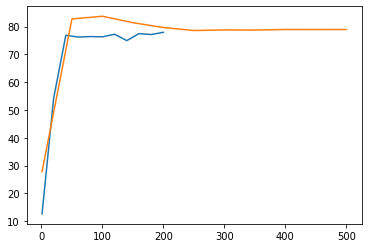

In [13]:
plt.clf()
plt.plot(np.append(1,np.arange(20,201,20)), NN_acc)
plt.plot(np.append(1,np.arange(50,501,50)), PL_acc)

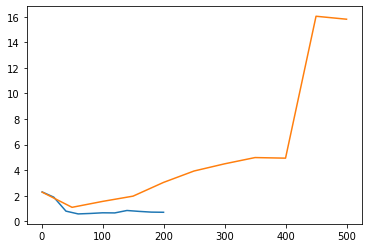

In [14]:
plt.clf()
plt.plot(np.append(1,np.arange(20,201,20)), NN_loss)
plt.plot(np.append(1,np.arange(50,501,50)), PL_loss)